In [68]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textblob
from textblob import TextBlob
import textblob.exceptions
from datetime import datetime
import time


import warnings
warnings.filterwarnings('ignore')

In [69]:
def translate_with_retry(blob_obj, from_lang, to_lang, max_retries=3, delay=1):
    attempt = 0
    while attempt < max_retries:
        try:
            translation = blob_obj.translate(from_lang=from_lang, to=to_lang)
            return translation
        except textblob.exceptions.NotTranslated:
            print(f'{blob_obj} is not translated')
            return blob_obj
        except ConnectionResetError as e:
            print(f"Encountered connection error: {e}. Retrying...")
            attempt += 1
            time.sleep(delay) 
    raise e

In [70]:
def textblob_idToEn_score(text):
  try:
    blob_obj = TextBlob(text=text)
    text_en = translate_with_retry(blob_obj, from_lang='id', to_lang='en')
  except textblob.exceptions.NotTranslated:
    print(f'{text} is not translated')
    text_en = TextBlob(text=text)

  score = text_en.sentiment.polarity
  return score

In [71]:
import locale
locale.setlocale(locale.LC_TIME, 'id_ID')

'id_ID'

In [72]:
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36'}

In [75]:
# Detik URL format https://www.detik.com/tag/{keyword_url}/?page={page_num} <-- salah karena tiap page > 24 bakal ngeredirect ke url di bawah & index nya reset lagi
# Detik URL format https://www.detik.com/search/searchall?query={keyword_url}&sortby=time&page={page_num}

def scrape_detik_news(keyword='pilpres 2024', start_date = '01 Jan 2024 00:00 WIB'):
  start_date = pd.Timestamp(start_date)
  keyword_url = keyword.replace(' ', '-')
  news = []
  month_mapping = {
    'Jan': 'Jan', 
    'Feb': 'Feb', 
    'Mar': 'Mar', 
    'Apr': 'Apr', 
    'Mei': 'May', 
    'Jun': "Jun",
    'Jul': 'Jul', 
    'Agu': 'Aug', 
    'Sep': 'Sep', 
    'Okt': 'Oct', 
    'Nov': 'Nov', 
    'Des': 'Dec'
}
  page_num = 1

  while True:
    page_url = f'https://www.detik.com/search/searchall?query={keyword_url}&sortby=time&page={page_num}'
    print(f'Scraping Detik Page {page_num}')

    page = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    # print(soup)

    articles = soup.find_all('article')

    for i in articles:
      a = i.find('a')
      date_spans = soup.find_all(class_='date')
      for date_span in date_spans:
        date_text = date_span.contents[1].strip()
      if date_text:
        date = date_text
      for indonesian_month, english_month in month_mapping.items():
        conv_date = date.split(', ')[1].replace(indonesian_month, english_month)
      conv_date = pd.to_datetime(conv_date)
      # print(conv_date)
      url = a.get('href')
      title = i.find('h2', 'title').text
      polarity = textblob_idToEn_score(title)

      if date_text : 
        news.append({
          'keyword' : keyword,
          'platform' : 'detik.com',
          'url' : url,
          'date' : date,
          'title' : title,
          'score' : polarity
        })

      # if not bool(i.find('h2', 'title')):
      #   break

    if conv_date < start_date:
      break

    page_num+=1
  return news


In [93]:
# Kompas url format https://www.kompas.com/tag/anies+baswedan?page=2

def scrape_kompas_news(keyword='pilpres 2024', start_date = '01 Jan 2024 00:00 WIB'):
  start_date = pd.Timestamp(start_date)
  keyword_url = keyword.replace(' ', '+')
  news = []

  page_num = 1

  while True:
    page_url = f' https://www.kompas.com/tag/{keyword_url}/?page={page_num}'
    print(f'Scraping Page Kompas {page_num}')

    page = requests.get(page_url)
    soup = BeautifulSoup(page.content, "html.parser")
    # print(soup)

    articles = soup.find_all('div', class_='article__list clearfix')
    
    for i in articles:
      info = i.find('div', class_='article__list__info')
      date_text = info.find('div', class_='article__date').text
      date_conv = pd.to_datetime(date_text)
      url = i.find('a').get('href')
      title = i.find('a').text
      date = date_text
      polarity = textblob_idToEn_score(title)

      news.append({
        'keyword' : keyword,
        'platform' : 'kompas.com',
        'url' : url,
        'date' : date,
        'title' : title,
        'score' : polarity
      })

      # if not bool(i.find('h2', 'title')):
      #   break

    if start_date > date_conv:
      break

    page_num+=1
  return news


In [123]:
# Liputan6 url format https://www.liputan6.com/tag/anies-baswedan?page=2

def scrape_liputan6_news(keyword='pilpres 2024', start_date = '01 Jan 2024 00:00 WIB'):
  start_date = pd.Timestamp(start_date)
  keyword_url = keyword.replace(' ', '-')
  news = []

  page_num = 1

  while True:
    page_url = f'https://www.liputan6.com/tag/{keyword_url}/?page={page_num}'
    print(f'Scraping Page Liputan6 {page_num}')

    page = requests.get(page_url)
    soup = BeautifulSoup(page.content, "html.parser")
    # print(soup)

    articles = soup.find_all('article')

    for i in articles:
      h4_element = i.find('h4')
      date = i.find_all('span', class_='articles--iridescent-list--text-item__datetime')
      if h4_element:
        a_element = h4_element.find('a')
        for j in date:
          date_text = j.text
        if a_element:
          url = a_element.get('href', '')
          title = a_element.get_text(strip=True)

          polarity = textblob_idToEn_score(title)

          # print({
          #   'keyword': keyword,
          #   'platform': 'liputan6.com',
          #   'url': url,
          #   'date':date_text,
          #   'title': title,
          #   'score': polarity
          # })
          news.append({
            'keyword': keyword,
            'platform': 'liputan6.com',
            'url': url,
            'date':date_text,
            'title': title,
            'score': polarity
          })


      # if not bool(i.find('h2', 'title')):
      #   break

    if page_num > 14:
      break

    page_num+=1
  return news

In [57]:
# # Tribun URL Format https://jabar.tribunnews.com/tag/anies-baswedan?page=2

# def scrape_tribun_news(keyword='pilpres 2024'):
#   keyword_url = keyword.replace(' ', '-')
#   news = []

#   page_num = 1

#   while True:
#     page_url = f'https://jabar.tribunnews.com/tag/{keyword_url}/?page={page_num}'
#     print(f'Scraping Page Tribun {page_num}')

#     page = requests.get(page_url)
#     soup = BeautifulSoup(page.content, "html.parser")
#     # print(soup)

#     i_element = soup.find_all('li', class_='ptb15')

#     for i in i_element:
#       if i_element:
#         a_element = i_element.find('a')

#         if a_element:
#           url = a_element.get('href')
#           title = a_element.get('title')

#           polarity = textblob_idToEn_score(title)

#           news.append({
#             'keyword': keyword,
#             'platform': 'jabar.tribunnews.com',
#             'url': url,
#             'title': title,
#             'score': polarity
#           })


#       # if not bool(i.find('h2', 'title')):
#       #   break

#     if page_num > 1:
#       break

#     page_num+=1
#   return news

In [76]:
anies_detik=scrape_detik_news('anies baswedan')

Scraping Detik Page 1
Scraping Detik Page 2
Scraping Detik Page 3
Scraping Detik Page 4
Scraping Detik Page 5
Scraping Detik Page 6
Scraping Detik Page 7
Scraping Detik Page 8
Scraping Detik Page 9
Scraping Detik Page 10
Scraping Detik Page 11
Scraping Detik Page 12
Scraping Detik Page 13
Scraping Detik Page 14
Scraping Detik Page 15
Scraping Detik Page 16
Scraping Detik Page 17
Scraping Detik Page 18
Scraping Detik Page 19
Scraping Detik Page 20
Scraping Detik Page 21
Scraping Detik Page 22
Scraping Detik Page 23
Scraping Detik Page 24
Scraping Detik Page 25
Scraping Detik Page 26
Scraping Detik Page 27
Scraping Detik Page 28
Scraping Detik Page 29
Scraping Detik Page 30
Scraping Detik Page 31
Scraping Detik Page 32
Scraping Detik Page 33
Scraping Detik Page 34
Scraping Detik Page 35
Scraping Detik Page 36
Scraping Detik Page 37
Scraping Detik Page 38
Scraping Detik Page 39
Scraping Detik Page 40
Scraping Detik Page 41
Scraping Detik Page 42
Scraping Detik Page 43
Scraping Detik Page 

In [77]:
anies_detik

[{'keyword': 'anies baswedan',
  'platform': 'detik.com',
  'url': 'https://www.detik.com/sulsel/berita/d-7180808/anies-janji-tingkatkan-fasilitas-trasportasi-komunikasi-di-parepare',
  'date': 'Selasa, 06 Feb 2024 17:05 WIB',
  'title': 'Anies Janji Tingkatkan Fasilitas Trasportasi-Komunikasi di Parepare',
  'score': 0.0},
 {'keyword': 'anies baswedan',
  'platform': 'detik.com',
  'url': 'https://www.detik.com/jateng/berita/d-7180777/cak-imin-sebut-erick-sebar-hoax-soal-bumn-tsamara-saya-rasa-kebalik-ya',
  'date': 'Selasa, 06 Feb 2024 17:05 WIB',
  'title': 'Cak Imin Sebut Erick Sebar Hoax soal BUMN, Tsamara: Saya Rasa Kebalik Ya',
  'score': 0.0},
 {'keyword': 'anies baswedan',
  'platform': 'detik.com',
  'url': 'https://www.detik.com/bali/nusra/d-7180747/kampanye-di-ntb-anies-minta-pendukung-lawan-pengganggu-arus-perubahan',
  'date': 'Selasa, 06 Feb 2024 17:05 WIB',
  'title': 'Kampanye di NTB, Anies Minta Pendukung Lawan Pengganggu Arus Perubahan',
  'score': 0.0},
 {'keyword':

In [94]:
anies_kompas=scrape_kompas_news('anies baswedan')

Scraping Page Kompas 1
Scraping Page Kompas 2
Scraping Page Kompas 3
Scraping Page Kompas 4
Scraping Page Kompas 5
Scraping Page Kompas 6
Scraping Page Kompas 7
Scraping Page Kompas 8
Scraping Page Kompas 9
Scraping Page Kompas 10
Scraping Page Kompas 11
Scraping Page Kompas 12
Scraping Page Kompas 13
Scraping Page Kompas 14
Scraping Page Kompas 15
Scraping Page Kompas 16
Scraping Page Kompas 17
Scraping Page Kompas 18
Scraping Page Kompas 19
Scraping Page Kompas 20
Scraping Page Kompas 21
Scraping Page Kompas 22
Scraping Page Kompas 23
Scraping Page Kompas 24
Scraping Page Kompas 25
Encountered connection error: [WinError 10054] An existing connection was forcibly closed by the remote host. Retrying...
Scraping Page Kompas 26
Scraping Page Kompas 27
Scraping Page Kompas 28
Scraping Page Kompas 29
Scraping Page Kompas 30
Scraping Page Kompas 31
Muhaimin: I Love Pak Ganjar is not translated
Scraping Page Kompas 32
Scraping Page Kompas 33
Scraping Page Kompas 34
Scraping Page Kompas 35
S

In [95]:
anies_kompas

[{'keyword': 'anies baswedan',
  'platform': 'kompas.com',
  'url': 'http://nasional.kompas.com/read/2024/02/06/16441541/di-hadapan-pendukungnya-anies-ini-bukan-orang-orang-yang-bisa-dibeli-harga',
  'date': '06/02/2024, 16:44 WIB',
  'title': 'Di Hadapan Pendukungnya, Anies: Ini Bukan Orang-orang yang Bisa Dibeli Harga Dirinya',
  'score': 0.0},
 {'keyword': 'anies baswedan',
  'platform': 'kompas.com',
  'url': 'http://regional.kompas.com/read/2024/02/06/164316278/anies-jangan-ada-yang-melanggar-etika-supaya-tak-mencederai-pemilu',
  'date': '06/02/2024, 16:43 WIB',
  'title': 'Anies: Jangan Ada yang Melanggar Etika supaya Tak Mencederai Pemilu',
  'score': 0.0},
 {'keyword': 'anies baswedan',
  'platform': 'kompas.com',
  'url': 'http://www.kompas.com/tren/read/2024/02/06/163000565/kata-anies-ganjar-soal-ketua-kpu-divonis-langgar-etik-loloskan-gibran',
  'date': '06/02/2024, 16:30 WIB',
  'title': 'Kata Anies-Ganjar soal Ketua KPU Divonis Langgar Etik Loloskan Gibran',
  'score': -0

In [124]:
anies_liputan=scrape_liputan6_news('anies baswedan')

Scraping Page Liputan6 1
Scraping Page Liputan6 2
Scraping Page Liputan6 3
Scraping Page Liputan6 4
Scraping Page Liputan6 5
Scraping Page Liputan6 6
Scraping Page Liputan6 7
Scraping Page Liputan6 8
Scraping Page Liputan6 9
Scraping Page Liputan6 10
Scraping Page Liputan6 11
Scraping Page Liputan6 12
Scraping Page Liputan6 13
Scraping Page Liputan6 14
Scraping Page Liputan6 15


In [125]:
anies_liputan

[{'keyword': 'anies baswedan',
  'platform': 'liputan6.com',
  'url': 'https://www.liputan6.com/pemilu/read/5522658/anies-sebut-putusan-dkpp-jadi-peringatan-bagi-kpu-jangan-lagi-ada-pelanggaran-etik',
  'date': '06 Feb 2024 17:48',
  'title': 'Anies Sebut Putusan DKPP Jadi Peringatan Bagi KPU, Jangan Lagi Ada Pelanggaran Etik',
  'score': -0.024999999999999994},
 {'keyword': 'anies baswedan',
  'platform': 'liputan6.com',
  'url': 'https://www.liputan6.com/bisnis/read/5522554/bukan-diubah-jadi-koperasi-begini-seharusnya-bumn-berjalan',
  'date': '06 Feb 2024 16:00',
  'title': 'Bukan Diubah Jadi Koperasi, Begini Seharusnya BUMN Berjalan',
  'score': 0.0},
 {'keyword': 'anies baswedan',
  'platform': 'liputan6.com',
  'url': 'https://www.liputan6.com/pemilu/read/5522494/survei-poltracking-basis-nu-jatim-60-persen-pilih-prabowo-gibran-ganjar-dan-anies-beda-tipis',
  'date': '06 Feb 2024 15:27',
  'title': 'Survei Poltracking: Basis NU Jatim 60 Persen Pilih Prabowo-Gibran, Ganjar dan Anie

In [126]:
prabowo_detik = scrape_detik_news('prabowo subianto')
ganjar_detik = scrape_detik_news('ganjar pranowo')

Scraping Detik Page 1
Scraping Detik Page 2
Scraping Detik Page 3
Scraping Detik Page 4
Scraping Detik Page 5
Scraping Detik Page 6
Scraping Detik Page 7
Encountered connection error: [WinError 10054] An existing connection was forcibly closed by the remote host. Retrying...
Scraping Detik Page 8
Scraping Detik Page 9
Scraping Detik Page 10
Scraping Detik Page 11
Scraping Detik Page 12
Scraping Detik Page 13
Scraping Detik Page 14
Scraping Detik Page 15
Scraping Detik Page 16
Scraping Detik Page 17
Scraping Detik Page 18
Scraping Detik Page 19
Scraping Detik Page 20
Scraping Detik Page 21
Scraping Detik Page 22
Scraping Detik Page 23
Scraping Detik Page 24
Scraping Detik Page 25
Scraping Detik Page 26
Scraping Detik Page 27
Scraping Detik Page 28
Scraping Detik Page 29
Scraping Detik Page 30
Scraping Detik Page 31
Scraping Detik Page 32
Scraping Detik Page 33
Scraping Detik Page 34
Scraping Detik Page 35
Scraping Detik Page 36
Scraping Detik Page 37
Scraping Detik Page 38
Scraping Deti

In [127]:
prabowo_kompas = scrape_kompas_news('prabowo subianto')
ganjar_kompas = scrape_kompas_news('ganjar pranowo')

Scraping Page Kompas 1
Scraping Page Kompas 2
Scraping Page Kompas 3
Scraping Page Kompas 4
Scraping Page Kompas 5
Scraping Page Kompas 6
Scraping Page Kompas 7
Scraping Page Kompas 8
Scraping Page Kompas 9
Scraping Page Kompas 10
Scraping Page Kompas 11
Scraping Page Kompas 12
Scraping Page Kompas 13
Scraping Page Kompas 14
Scraping Page Kompas 15
Scraping Page Kompas 16
Scraping Page Kompas 17
Scraping Page Kompas 18
Scraping Page Kompas 19
Scraping Page Kompas 20
Scraping Page Kompas 21
Encountered connection error: [WinError 10054] An existing connection was forcibly closed by the remote host. Retrying...
Scraping Page Kompas 22
Scraping Page Kompas 23
Scraping Page Kompas 24
Scraping Page Kompas 25
Scraping Page Kompas 26
Scraping Page Kompas 27
Scraping Page Kompas 28
Scraping Page Kompas 29
Scraping Page Kompas 30
Scraping Page Kompas 31
Scraping Page Kompas 32
Scraping Page Kompas 33
Scraping Page Kompas 34
Scraping Page Kompas 35
Scraping Page Kompas 36
Scraping Page Kompas 37

In [128]:
prabowo_liputan6 = scrape_liputan6_news('prabowo subianto')
ganjar_liputan6 = scrape_liputan6_news('ganjar pranowo')

Scraping Page Liputan6 1
Scraping Page Liputan6 2
Scraping Page Liputan6 3
Scraping Page Liputan6 4
Scraping Page Liputan6 5
Scraping Page Liputan6 6
Scraping Page Liputan6 7
Scraping Page Liputan6 8
Scraping Page Liputan6 9
Scraping Page Liputan6 10
Scraping Page Liputan6 11
Scraping Page Liputan6 12
Scraping Page Liputan6 13
Scraping Page Liputan6 14
Scraping Page Liputan6 15
Scraping Page Liputan6 1
Scraping Page Liputan6 2
Scraping Page Liputan6 3
Scraping Page Liputan6 4
Scraping Page Liputan6 5
Scraping Page Liputan6 6
Scraping Page Liputan6 7
Scraping Page Liputan6 8
Scraping Page Liputan6 9
Scraping Page Liputan6 10
Scraping Page Liputan6 11
Scraping Page Liputan6 12
Scraping Page Liputan6 13
Scraping Page Liputan6 14
Scraping Page Liputan6 15


In [129]:
import pandas as pd

df_anies_detik = pd.DataFrame(anies_detik)
df_anies_kompas = pd.DataFrame(anies_kompas)
df_anies_liputan = pd.DataFrame(anies_liputan)

df_prabowo_detik = pd.DataFrame(prabowo_detik)
df_prabowo_kompas = pd.DataFrame(prabowo_kompas)
df_prabowo_liputan = pd.DataFrame(prabowo_liputan6)

df_ganjar_detik = pd.DataFrame(ganjar_detik)
df_ganjar_kompas = pd.DataFrame(ganjar_kompas)
df_ganjar_liputan = pd.DataFrame(ganjar_liputan6)

In [138]:
df_anies_detik

,keyword,platform,url,date,title,score
0,anies baswedan,detik.com,https://www.detik.com/sulsel/berita/d-7180808/...,"Selasa, 06 Feb 2024 17:05 WIB",Anies Janji Tingkatkan Fasilitas Trasportasi-K...,0.000000
1,anies baswedan,detik.com,https://www.detik.com/jateng/berita/d-7180777/...,"Selasa, 06 Feb 2024 17:05 WIB","Cak Imin Sebut Erick Sebar Hoax soal BUMN, Tsa...",0.000000
2,anies baswedan,detik.com,https://www.detik.com/bali/nusra/d-7180747/kam...,"Selasa, 06 Feb 2024 17:05 WIB","Kampanye di NTB, Anies Minta Pendukung Lawan P...",0.000000
3,anies baswedan,detik.com,https://www.detik.com/sumut/berita/d-7180150/j...,"Selasa, 06 Feb 2024 17:05 WIB","Jawab Mahfud soal Dikendalikan Seperti Bebek, ...",0.000000
4,anies baswedan,detik.com,https://www.detik.com/jatim/berita/d-7180711/h...,"Selasa, 06 Feb 2024 17:05 WIB",Hasil Survei Poltracking: Prabowo-Gibran Menan...,0.500000
...,...,...,...,...,...,...
2227,anies baswedan,detik.com,https://www.detik.com/sumut/berita/d-7118257/a...,"Minggu, 31 Des 2023 19:53 WIB","Anies Jalan-jalan di Malioboro, Ada yang Teria...",0.000000
2228,anies baswedan,detik.com,https://www.detik.com/jogja/berita/d-7118241/t...,"Minggu, 31 Des 2023 19:53 WIB",Teriakan 'Prabowo Presiden' Saat Anies Jalan-j...,0.000000
2229,anies baswedan,detik.com,https://www.detik.com/jogja/berita/d-7118207/t...,"Minggu, 31 Des 2023 19:53 WIB","Tahun Baruan di Jogja, Anies Baswedan Sekeluar...",0.136364
2230,anies baswedan,detik.com,https://news.detik.com/pemilu/d-7118093/kapten...,"Minggu, 31 Des 2023 19:53 WIB",Kapten AMIN: Pernyataan Sudirman Said soal Wak...,0.000000


In [230]:
df_anies_detik.to_csv('df_anies_detik-070224.csv')
df_anies_kompas.to_csv('df_anies_kompas-070224.csv')
df_anies_liputan.to_csv('df_anies_liputan-070224.csv')

In [139]:
df_prabowo_detik

,keyword,platform,url,date,title,score
0,prabowo subianto,detik.com,https://news.detik.com/pemilu/d-7180937/relawa...,"Selasa, 06 Feb 2024 19:55 WIB",Relawan Samawi Sosialisasikan Visi Misi Prabow...,0.0
1,prabowo subianto,detik.com,https://news.detik.com/pemilu/d-7180867/kata-g...,"Selasa, 06 Feb 2024 19:55 WIB",Kata Gerindra soal Mahfud Bilang Pimpinan Parp...,0.0
2,prabowo subianto,detik.com,https://www.detik.com/jogja/berita/d-7180859/g...,"Selasa, 06 Feb 2024 19:55 WIB",Ganjar Beberkan Alasan Ajak Makan Bareng Pendu...,0.0
3,prabowo subianto,detik.com,https://news.detik.com/pemilu/d-7180854/tkn-du...,"Selasa, 06 Feb 2024 19:55 WIB",TKN Duga Kecurangan Surat Suara di Malaysia Li...,0.0
4,prabowo subianto,detik.com,https://news.detik.com/pemilu/d-7180852/barisa...,"Selasa, 06 Feb 2024 19:55 WIB",Barisan RFG Tebus Murah 2.000 Paket Sembako di...,0.4
...,...,...,...,...,...,...
3037,prabowo subianto,detik.com,https://www.detik.com/sumut/berita/d-7118151/p...,"Minggu, 31 Des 2023 21:24 WIB",Penampakan Spanduk Prabowo-Gibran yang Tutupi ...,0.8
3038,prabowo subianto,detik.com,https://www.detik.com/sumut/berita/d-7118257/a...,"Minggu, 31 Des 2023 21:24 WIB","Anies Jalan-jalan di Malioboro, Ada yang Teria...",0.0
3039,prabowo subianto,detik.com,https://www.detik.com/jogja/berita/d-7118241/t...,"Minggu, 31 Des 2023 21:24 WIB",Teriakan 'Prabowo Presiden' Saat Anies Jalan-j...,0.0
3040,prabowo subianto,detik.com,https://travel.detik.com/travel-news/d-7118069...,"Minggu, 31 Des 2023 21:24 WIB",Spanduk Prabowo-Gibran di Monumen Welcome to B...,0.8


In [231]:
df_prabowo_detik.to_csv('df_prabowo_detik-070224.csv')
df_prabowo_kompas.to_csv('df_prabowo_kompas-070224.csv')
df_prabowo_liputan.to_csv('df_prabowo_liputan-070224.csv')

In [140]:
df_ganjar_detik

,keyword,platform,url,date,title,score
0,ganjar pranowo,detik.com,https://www.detik.com/jatim/berita/d-7180956/e...,"Selasa, 06 Feb 2024 19:30 WIB",Elektabilitas Prabowo-Gibran di Jatim Capai 60...,0.000000
1,ganjar pranowo,detik.com,https://news.detik.com/pemilu/d-7180892/jika-j...,"Selasa, 06 Feb 2024 19:30 WIB","Jika Jadi Presiden, Ganjar Janji Tak Batasi Pe...",0.000000
2,ganjar pranowo,detik.com,https://www.detik.com/jogja/berita/d-7180859/g...,"Selasa, 06 Feb 2024 19:30 WIB",Ganjar Beberkan Alasan Ajak Makan Bareng Pendu...,0.000000
3,ganjar pranowo,detik.com,https://www.detik.com/jogja/berita/d-7180856/b...,"Selasa, 06 Feb 2024 19:30 WIB","Banyak Kampus Kritik Jokowi, Ganjar: Kita Tak ...",0.500000
4,ganjar pranowo,detik.com,https://www.detik.com/jogja/berita/d-7180835/p...,"Selasa, 06 Feb 2024 19:30 WIB","Projo Cabut Laporan terhadap Butet, Begini Res...",0.000000
...,...,...,...,...,...,...
2362,ganjar pranowo,detik.com,https://www.detik.com/sumut/berita/d-7118266/g...,"Minggu, 31 Des 2023 23:57 WIB",Ganjar Bakal Siapkan Rp 4 T untuk Insentif Gur...,0.000000
2363,ganjar pranowo,detik.com,https://www.detik.com/jateng/berita/d-7118402/...,"Minggu, 31 Des 2023 23:57 WIB","Usai Jenguk Relawan yang Dianiaya TNI, Ganjar:...",0.000000
2364,ganjar pranowo,detik.com,https://news.detik.com/pemilu/d-7118373/ganjar...,"Minggu, 31 Des 2023 23:57 WIB",Ganjar Ungkap Kondisi Relawan Korban Pengeroyo...,0.000000
2365,ganjar pranowo,detik.com,https://news.detik.com/pemilu/d-7118354/ganjar...,"Minggu, 31 Des 2023 23:57 WIB","Ganjar Sambut Tahun Baru dengan Istighosah, Ha...",0.318182


In [234]:
df_ganjar_detik.to_csv('df_ganjar_detik-070224.csv')
df_ganjar_kompas.to_csv('df_ganjar_kompas-070224.csv')
df_ganjar_liputan.to_csv('df_ganjar_liputan-070224.csv')

In [141]:
def content_info(df):
  df = df.copy()
  keyword = df.loc[0,'keyword']

  df['pos'] = np.where(df.score > 0, 1, 0)
  df['neu'] = np.where(df.score == 0, 1, 0)
  df['neg'] = np.where(df.score < 0, 1, 0)

  print(f'Total data with keyword {keyword} : {df.shape[0]}')
  print(f'With {df.pos.sum()} positive, {df.neu.sum()} neutral, {df.neg.sum()} negative')

In [142]:
print('Anies : ')
content_info(df_anies_kompas)
content_info(df_anies_detik)
content_info(df_anies_liputan)

Anies : 
Total data with keyword anies baswedan : 690
With 200 positive, 414 neutral, 76 negative
Total data with keyword anies baswedan : 2232
With 567 positive, 1388 neutral, 277 negative
Total data with keyword anies baswedan : 315
With 105 positive, 178 neutral, 32 negative


In [143]:
print('Prabowo : ')
content_info(df_prabowo_kompas)
content_info(df_prabowo_detik)
content_info(df_prabowo_liputan)

Prabowo : 
Total data with keyword prabowo subianto : 600
With 169 positive, 360 neutral, 71 negative
Total data with keyword prabowo subianto : 3042
With 872 positive, 1835 neutral, 335 negative
Total data with keyword prabowo subianto : 315
With 115 positive, 170 neutral, 30 negative


In [144]:
print('Ganjar : ')
content_info(df_ganjar_kompas)
content_info(df_ganjar_detik)
content_info(df_ganjar_liputan)

Ganjar : 
Total data with keyword ganjar pranowo : 585
With 159 positive, 347 neutral, 79 negative
Total data with keyword ganjar pranowo : 2367
With 660 positive, 1433 neutral, 274 negative
Total data with keyword ganjar pranowo : 315
With 108 positive, 174 neutral, 33 negative


In [145]:
def data_visualization(df, name):
  df = df.copy()

  df['pos'] = np.where(df.score > 0, 1, 0)
  df['neu'] = np.where(df.score == 0, 1, 0)
  df['neg'] = np.where(df.score < 0, 1, 0)
  
  tmp_df = df.groupby(['keyword'])[['pos', 'neu', 'neg']].sum().reset_index()

  key = list(tmp_df.keyword.unique())
  df_map = tmp_df[['pos', 'neu', 'neg']].to_dict(orient='list')

  x = np.arange(len(key))
  width = 0.25
  multiplier = 0  

  fig, ax = plt.subplots()

  for attr, measurement in df_map.items():
    offset = width*multiplier
    if attr=='pos':
      color='green'
    elif attr=='neu':
      color='lightblue'
    else:
      color='red'
    rects=ax.bar(x+offset, measurement, width, label=attr, color=color)
    ax.bar_label(rects, padding=3)
    multiplier+=1

  ax.set_ylabel('Count')
  ax.set_title(f'Sentiment Analysis for News on {name}')
  ax.set_xticks(x + width * (multiplier - 1) / 2 )
  ax.set_xticklabels(key, ha='center')
  ax.legend(loc = 'upper left', bbox_to_anchor=(1,1))

  plt.show()


In [281]:
def plot_linegraph(df, name, source):
  df = df.groupby(['keyword', 'date'])['score'].mean().reset_index()
  df.columns = ['keyword', 'date', 'avg score']
  df['date'] = df['date'].str.split(', ').str[-1]

  df = df.sort_values('date')

  plt.figure(figsize=(15, 6))
  plt.plot(df['date'], df['avg score'], linestyle='-')
  plt.title(f'{name} \'s Article Sentiment Score over Time in {source}')
  plt.xlabel('Date')
  plt.ylabel('Score')
  plt.xticks(rotation=90)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [146]:
df_all_detik = pd.concat([df_anies_detik, df_prabowo_detik, df_ganjar_detik]).reset_index(drop=True)

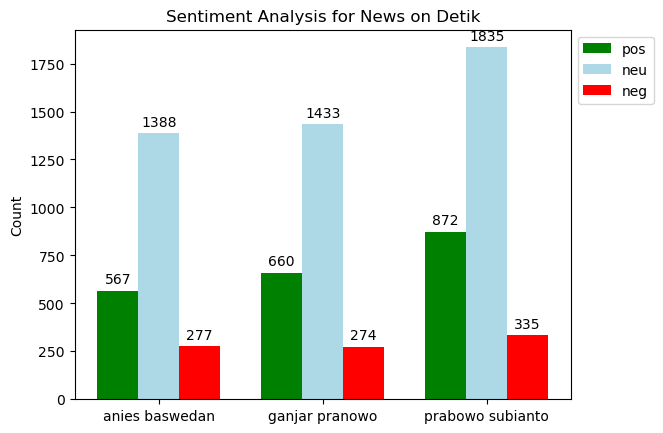

In [147]:
data_visualization(df_all_detik, 'Detik')

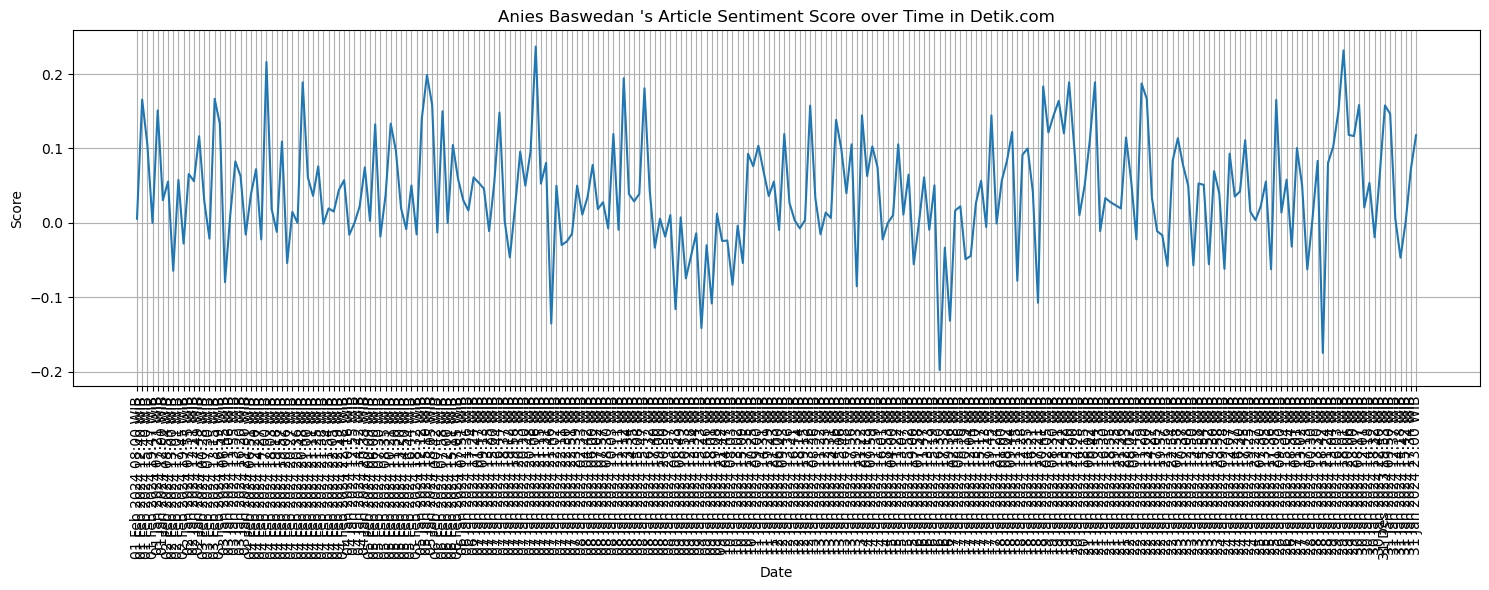

In [282]:
plot_linegraph(df_anies_detik, 'Anies Baswedan', 'Detik.com')

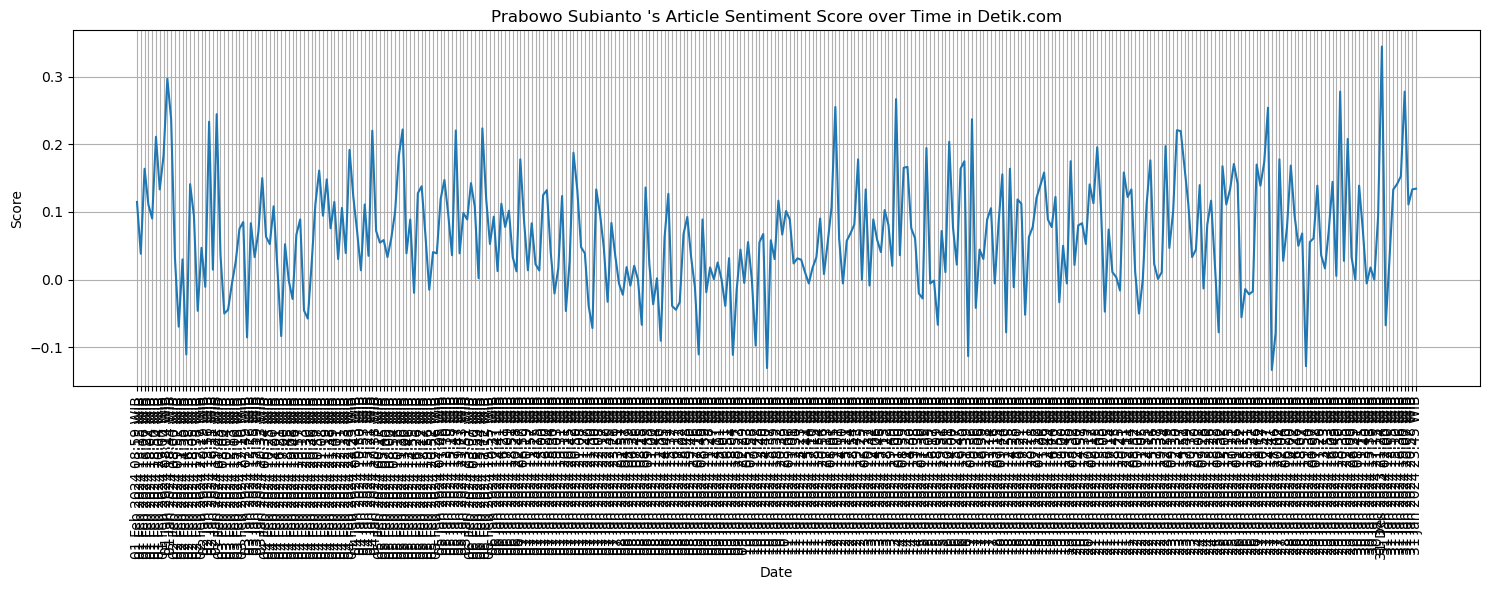

In [283]:
plot_linegraph(df_prabowo_detik, 'Prabowo Subianto', 'Detik.com')

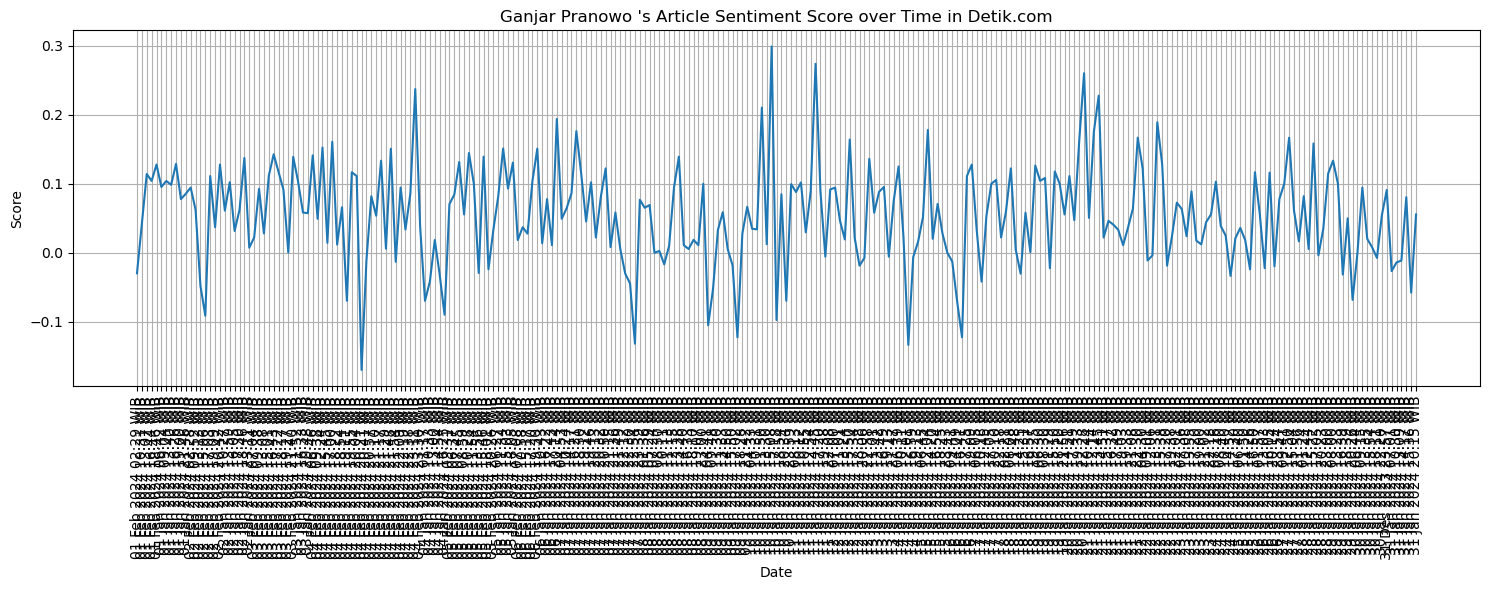

In [284]:
plot_linegraph(df_ganjar_detik, 'Ganjar Pranowo', 'Detik.com')

In [148]:
df_all_kompas = pd.concat([df_anies_kompas, df_prabowo_kompas, df_ganjar_kompas]).reset_index(drop=True)

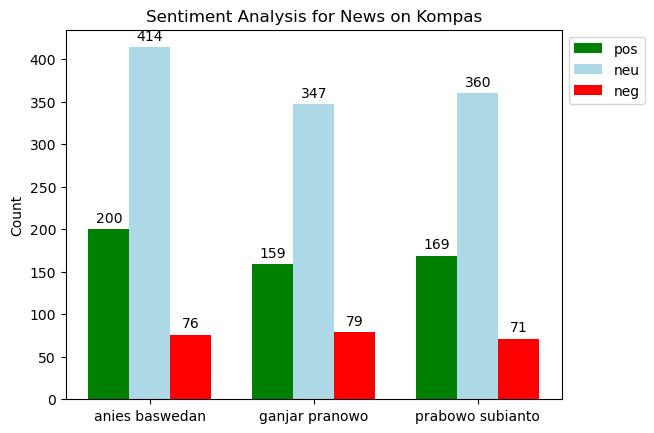

In [149]:
data_visualization(df_all_kompas, 'Kompas')

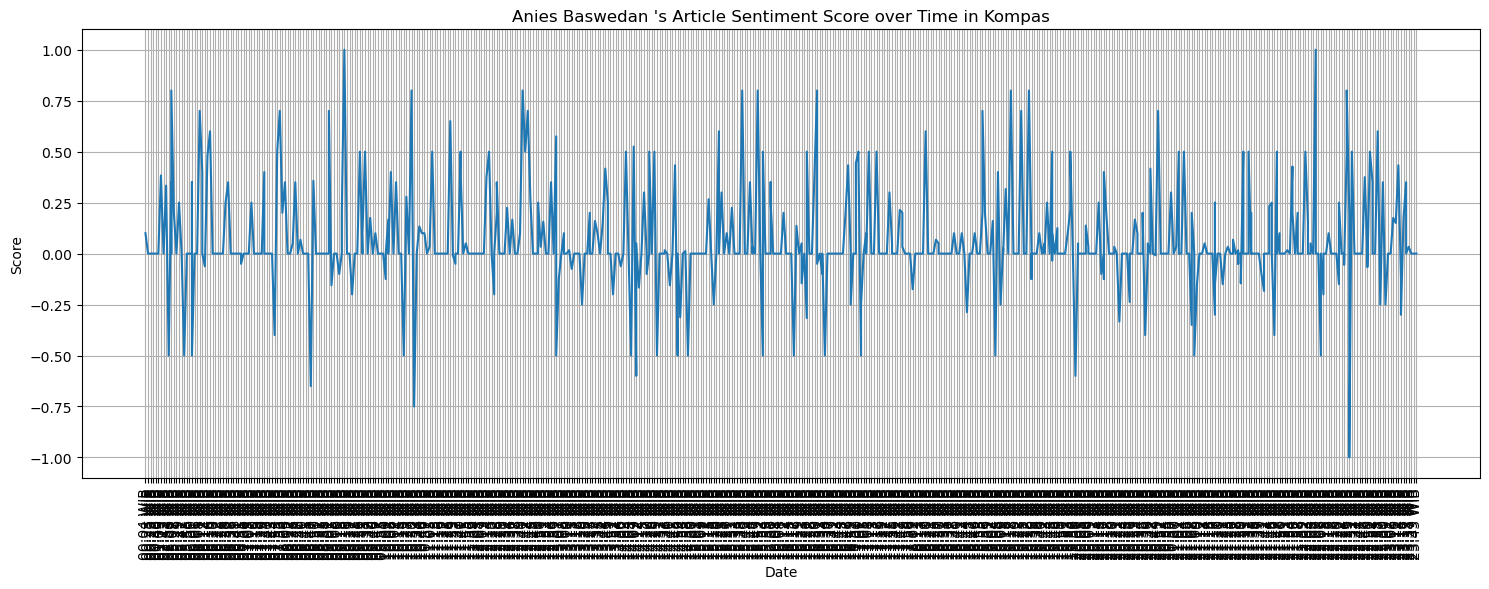

In [285]:
plot_linegraph(df_anies_kompas, 'Anies Baswedan', 'Kompas')

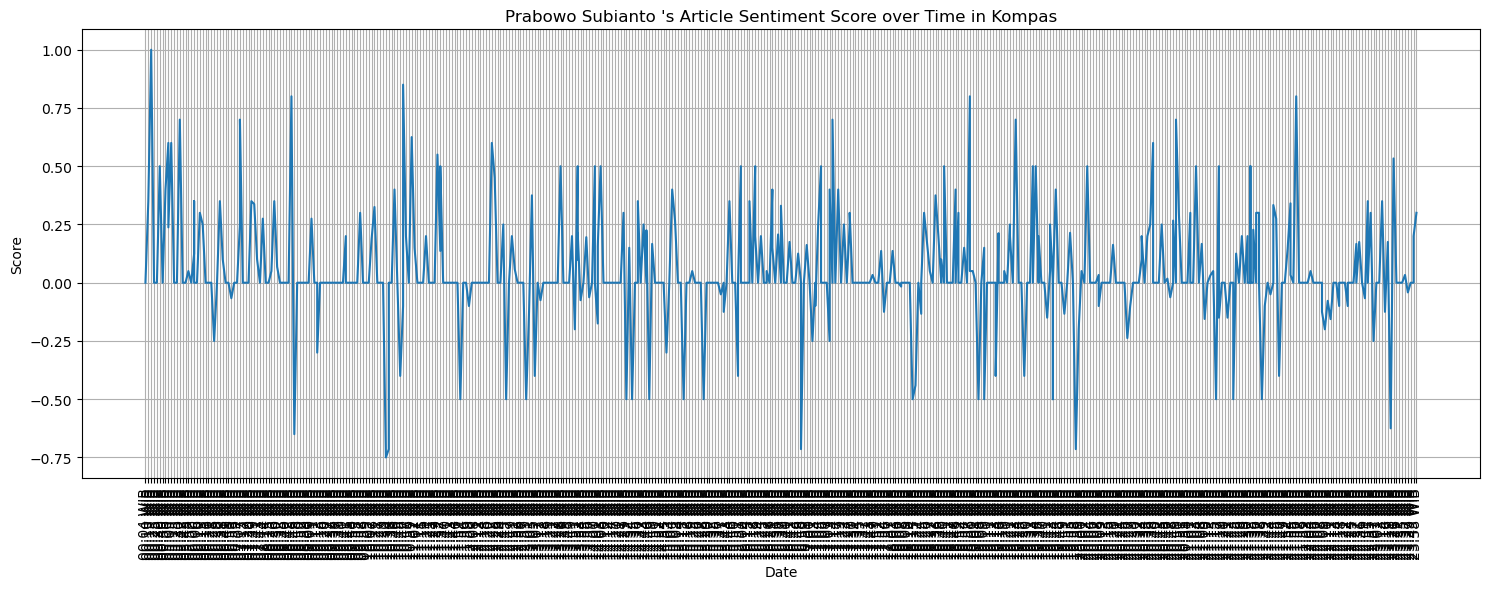

In [286]:
plot_linegraph(df_prabowo_kompas, 'Prabowo Subianto', 'Kompas')

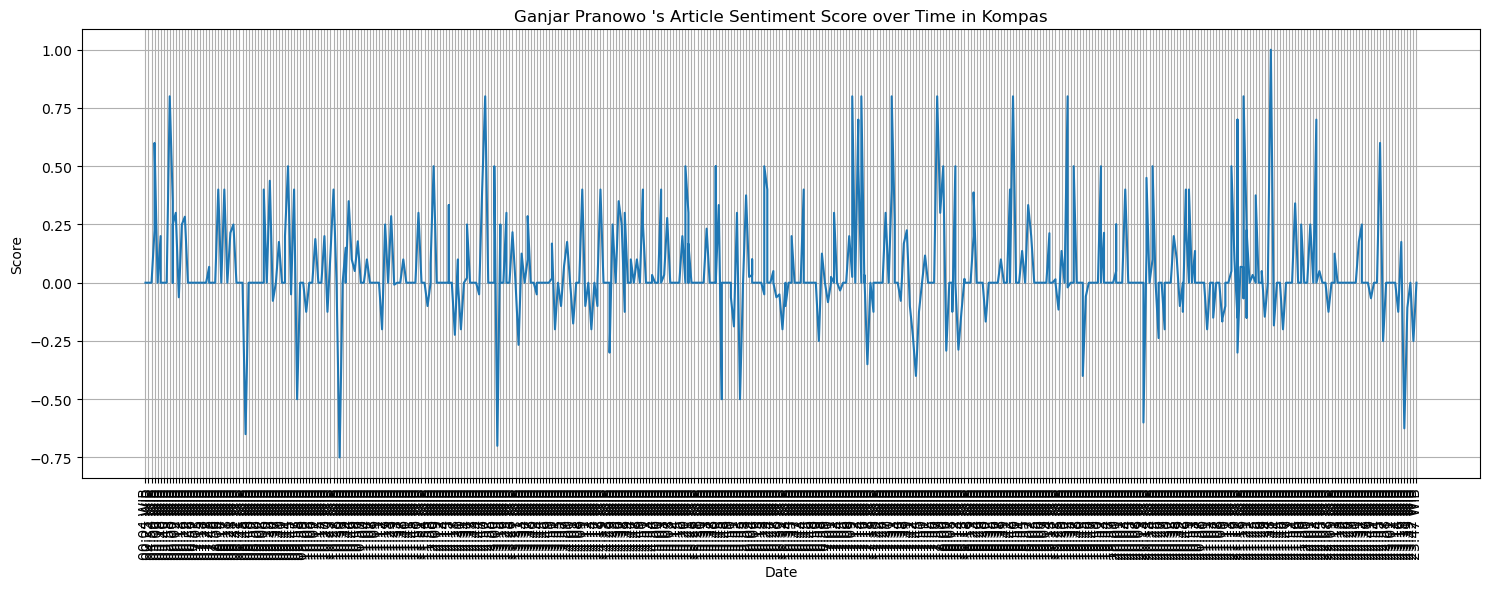

In [287]:
plot_linegraph(df_ganjar_kompas, 'Ganjar Pranowo', 'Kompas')

In [150]:
df_all_liputan = pd.concat([df_anies_liputan, df_prabowo_liputan, df_ganjar_liputan]).reset_index(drop=True)

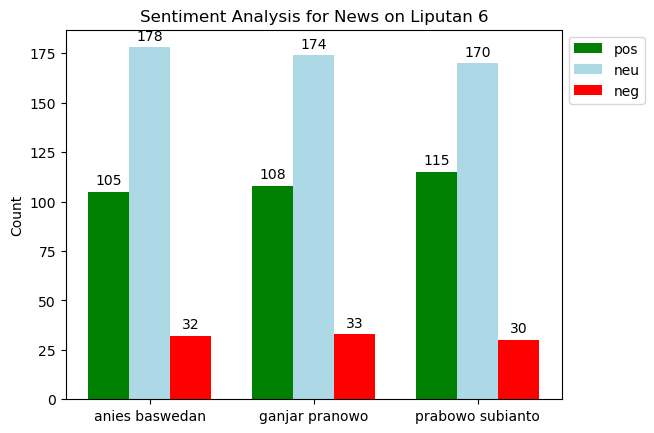

In [151]:
data_visualization(df_all_liputan, 'Liputan 6')

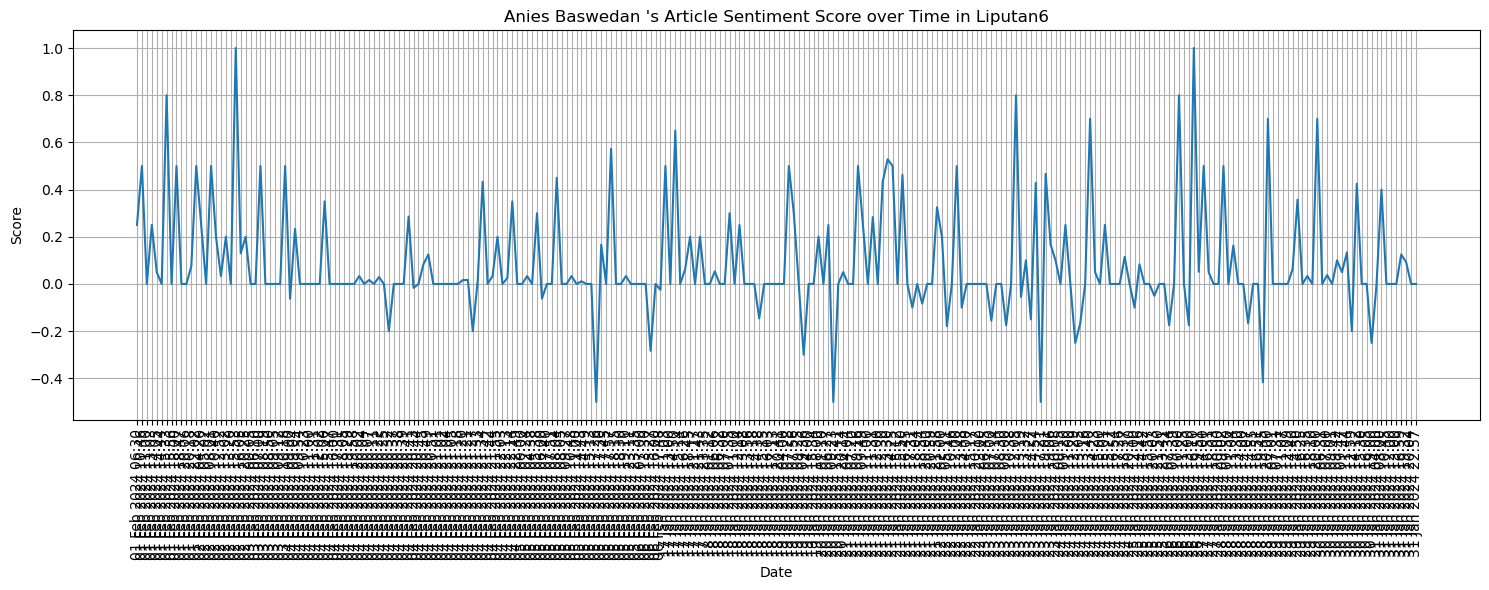

In [288]:
plot_linegraph(df_anies_liputan, 'Anies Baswedan', 'Liputan6')

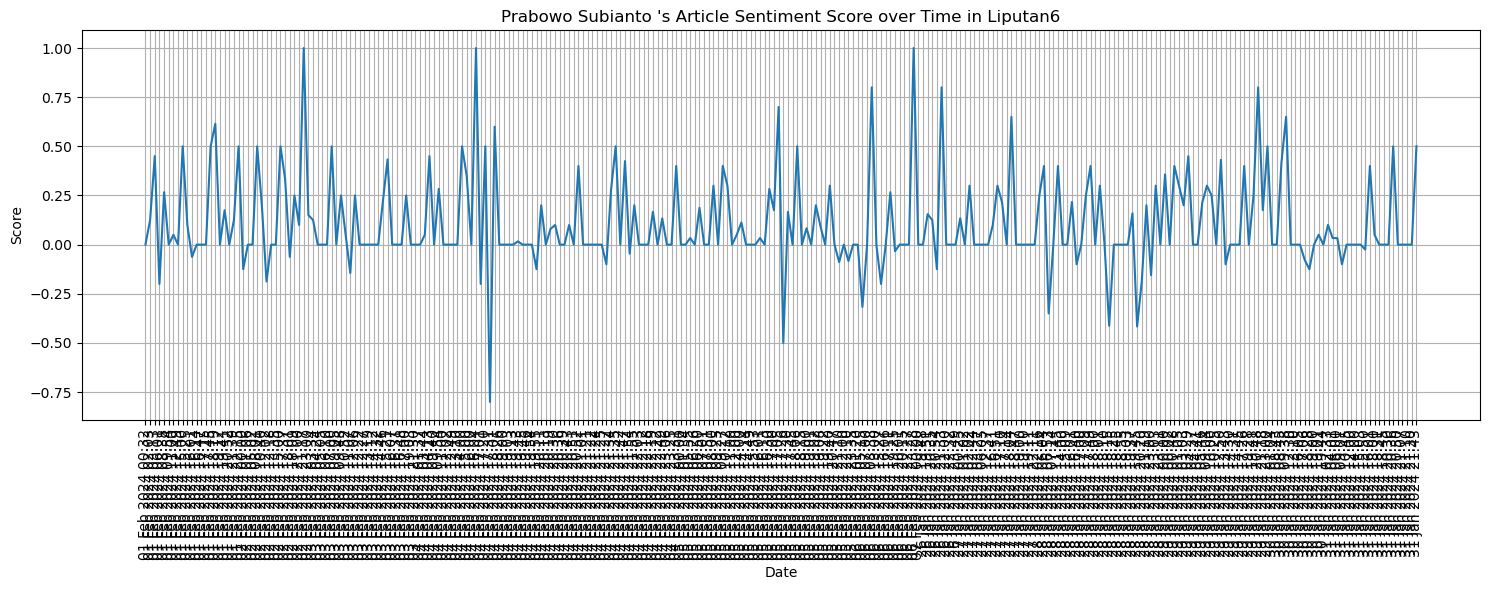

In [289]:
plot_linegraph(df_prabowo_liputan, 'Prabowo Subianto', 'Liputan6')

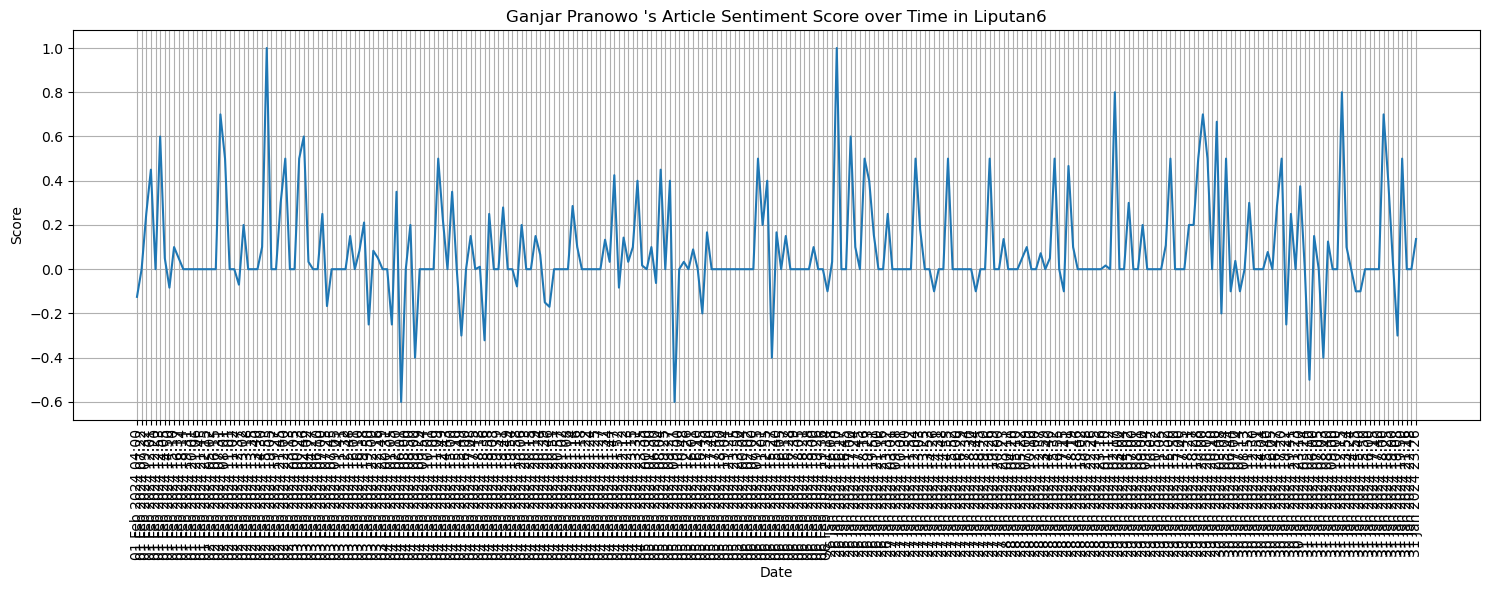

In [290]:
plot_linegraph(df_ganjar_liputan, 'Ganjar Pranowo', 'Liputan6')

In [152]:
df_all_3sources = pd.concat([df_all_detik, df_all_kompas, df_all_liputan]).reset_index(drop=True)

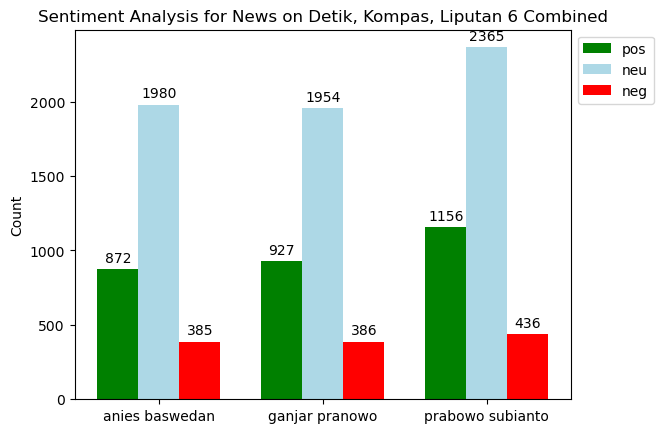

In [153]:
data_visualization(df_all_3sources, 'Detik, Kompas, Liputan 6 Combined')

In [154]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [155]:
stopwords = ['di', 'ke', 'untuk', 'dari', 'dan', 'ini', 'itu', 'juga', 'saat']

In [156]:
def wc(df, img_path):
  text = ' '.join([i for i in df.title])
  print(f'There are {len(text)} words from news title with keyword {df["keyword"].unique()}')

  mask = np.array(Image.open(img_path))
  wordcloud_por = WordCloud(stopwords=stopwords, background_color='white', max_words=5000, mask=mask).generate(text)

  image_colors=ImageColorGenerator(mask)
  plt.figure(figsize=(7,7))
  plt.imshow(wordcloud_por.recolor(color_func=image_colors))
  plt.axis('off')
  plt.show()

In [157]:
df_all_3sources

,keyword,platform,url,date,title,score
0,anies baswedan,detik.com,https://www.detik.com/sulsel/berita/d-7180808/...,"Selasa, 06 Feb 2024 17:05 WIB",Anies Janji Tingkatkan Fasilitas Trasportasi-K...,0.000000
1,anies baswedan,detik.com,https://www.detik.com/jateng/berita/d-7180777/...,"Selasa, 06 Feb 2024 17:05 WIB","Cak Imin Sebut Erick Sebar Hoax soal BUMN, Tsa...",0.000000
2,anies baswedan,detik.com,https://www.detik.com/bali/nusra/d-7180747/kam...,"Selasa, 06 Feb 2024 17:05 WIB","Kampanye di NTB, Anies Minta Pendukung Lawan P...",0.000000
3,anies baswedan,detik.com,https://www.detik.com/sumut/berita/d-7180150/j...,"Selasa, 06 Feb 2024 17:05 WIB","Jawab Mahfud soal Dikendalikan Seperti Bebek, ...",0.000000
4,anies baswedan,detik.com,https://www.detik.com/jatim/berita/d-7180711/h...,"Selasa, 06 Feb 2024 17:05 WIB",Hasil Survei Poltracking: Prabowo-Gibran Menan...,0.500000
...,...,...,...,...,...,...
10456,ganjar pranowo,liputan6.com,https://www.liputan6.com/pemilu/read/5514601/g...,26 Jan 2024 17:00,Ganjar Disambut Hangat Warga di Stadion Golo D...,0.600000
10457,ganjar pranowo,liputan6.com,https://www.liputan6.com/pemilu/read/5514586/g...,26 Jan 2024 16:45,"Ganjar: Silakan Kalau Presiden Akan Kampanye, ...",0.000000
10458,ganjar pranowo,liputan6.com,https://www.liputan6.com/pemilu/read/5514679/j...,26 Jan 2024 16:27,"Jaga Momentum Jelang Pilpres 2024, TPN Ganjar-...",0.000000
10459,ganjar pranowo,liputan6.com,https://www.liputan6.com/pemilu/read/5514545/s...,26 Jan 2024 16:10,Survei Polling Institute: Prabowo Dinilai Tamp...,1.000000


There are 225515 words from news title with keyword ['anies baswedan']


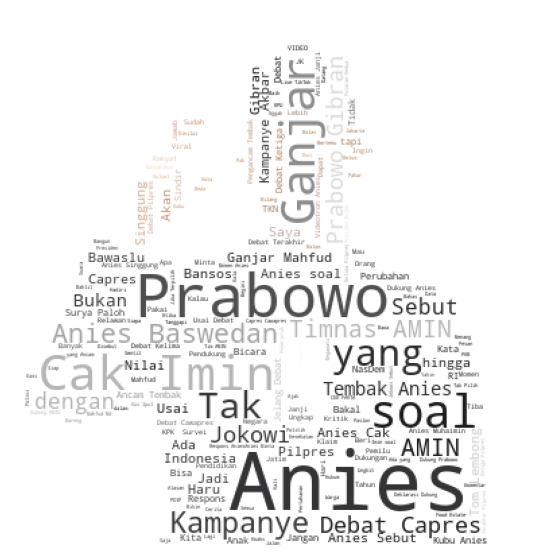

In [158]:
wc(df_all_3sources[df_all_3sources['keyword'] == 'anies baswedan'], './mask_images/anies-PhotoRoom.png-PhotoRoom.png')

There are 274832 words from news title with keyword ['prabowo subianto']


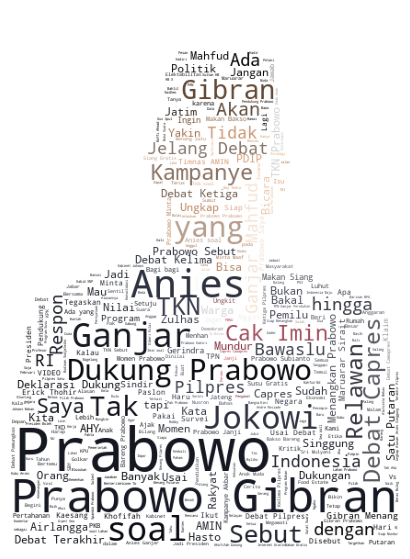

In [159]:
wc(df_all_3sources[df_all_3sources['keyword'] == 'prabowo subianto'], './mask_images/prabowo-PhotoRoom.png-PhotoRoom.png')

There are 227447 words from news title with keyword ['ganjar pranowo']


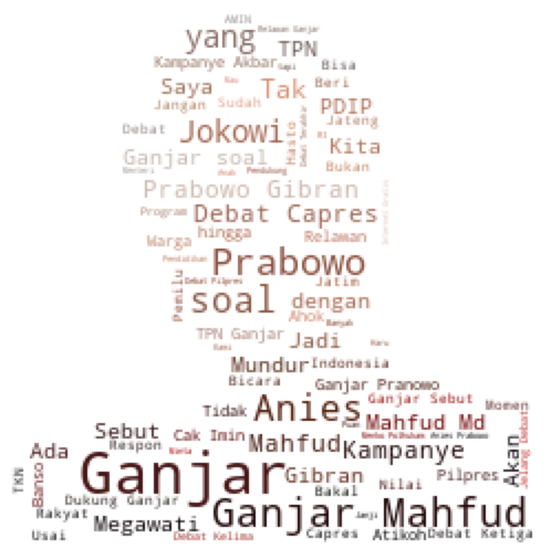

In [160]:
wc(df_all_3sources[df_all_3sources['keyword'] == 'ganjar pranowo'], './mask_images/ganjar-pranowo-PhotoRoom.png-PhotoRoom.png')